## Load the data

####  Import libraries

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.utils

import csv
import pandas as pd
import numpy as np
from numpy.random import seed
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

seed(57)

#### Load dataset

In [2]:
features = pd.read_csv('data/train_values.csv')
labels = pd.read_csv('data/train_labels.csv')

##  Summaries The Dataset

In [3]:
features.drop('patient_id', 1, inplace=True)
labels.drop('patient_id', 1, inplace=True)

In [4]:
features.shape

(180, 13)

In [5]:
features.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [6]:
features.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,1.550000,131.311111,3.155556,0.694444,0.161111,1.050000,249.211111,1.010000,0.688889,54.811111,149.483333,0.316667
std,0.618838,17.010443,0.938454,0.969347,0.368659,0.998742,52.717969,1.121357,0.464239,9.334737,22.063513,0.466474
min,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,29.000000,96.000000,0.000000
25%,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,213.750000,0.000000,0.000000,48.000000,132.000000,0.000000
50%,1.000000,130.000000,3.000000,0.000000,0.000000,2.000000,245.500000,0.800000,1.000000,55.000000,152.000000,0.000000
75%,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,281.250000,1.600000,1.000000,62.000000,166.250000,1.000000
max,3.000000,180.000000,4.000000,3.000000,1.000000,2.000000,564.000000,6.200000,1.000000,77.000000,202.000000,1.000000


In [7]:
features.groupby('thal').size()

thal
fixed_defect          8
normal               98
reversible_defect    74
dtype: int64

In [8]:
labels.groupby('heart_disease_present').size()

heart_disease_present
0    100
1     80
dtype: int64

In [9]:
CATEGORICAL_FEATURE_KEYS = []
NUMERIC_FEATURE_KEYS = []
LABEL_KEY = ''

## Data Visualization

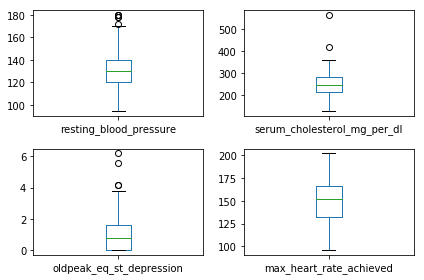

In [10]:
X_viz = features[['resting_blood_pressure', 'serum_cholesterol_mg_per_dl',
           'oldpeak_eq_st_depression', 'max_heart_rate_achieved']]
X_viz.plot(kind='box', subplots=True, layout=(2, 2), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

####  Multivariate plots

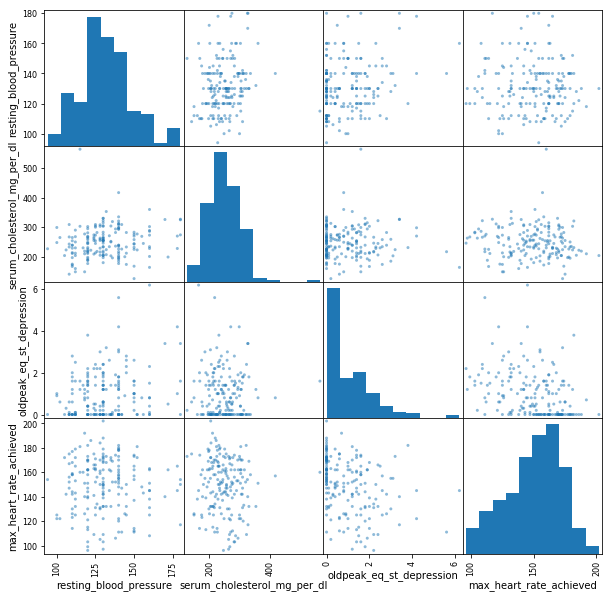

In [11]:
# scatter plot matrix
scatter_matrix(X_viz, figsize=(10, 10))
plt.show()

No sign of correlation between these 4 features. The 'old_eq_st_depression' feature seems to have the Fisher–Snedecor distribution. This feature should be maybe transformed to the Guassian distributed.

##  Transform the dataset

In [12]:
features['thal'] = features['thal'].astype('category')
features['thal'] = features['thal'].cat.codes

In [13]:
features.dtypes

slope_of_peak_exercise_st_segment         int64
thal                                       int8
resting_blood_pressure                    int64
chest_pain_type                           int64
num_major_vessels                         int64
fasting_blood_sugar_gt_120_mg_per_dl      int64
resting_ekg_results                       int64
serum_cholesterol_mg_per_dl               int64
oldpeak_eq_st_depression                float64
sex                                       int64
age                                       int64
max_heart_rate_achieved                   int64
exercise_induced_angina                   int64
dtype: object

##  Evaluate Algorithms

In [14]:
X = features.values
Y = labels.values
X = preprocessing.scale(X)
#normalizer.transform(X)

validation_size = 0.25
seed = 10
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(
                                                            X, Y, test_size=validation_size, random_state=seed)

In [16]:
test_features = pd.read_csv('data/test_values.csv')
patient = test_features['patient_id']
test_features.drop('patient_id', 1, inplace=True)
test_features['thal'] = test_features['thal'].astype('category')
test_features.dtypes
test_features['thal'] = test_features['thal'].cat.codes
X_test = preprocessing.scale(test_features.values)

In [17]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=2500)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto', probability=True)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=18, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train.ravel(), cv=kfold, scoring='accuracy', error_score='raise')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.789683 (0.171853)
LDA: 0.791667 (0.181035)
KNN: 0.772817 (0.134661)
CART: 0.701389 (0.156561)
NB: 0.797619 (0.157260)
SVM: 0.781746 (0.144406)


In [18]:
# Make predictions on validation dataset
svm= CalibratedClassifierCV(SVC(C=0.70, gamma='auto'))

#svm= GaussianNB()
cv = ShuffleSplit()
svm.fit(X_train, Y_train.ravel())
predictions = svm.predict(X_validation)

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8666666666666667
[[25  3]
 [ 3 14]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        28
           1       0.82      0.82      0.82        17

   micro avg       0.87      0.87      0.87        45
   macro avg       0.86      0.86      0.86        45
weighted avg       0.87      0.87      0.87        45



c:\users\mfundo\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [20]:
#svm.probability = True
final_scores = svm.predict_proba(X_test)

In [21]:
rows = zip(patient, final_scores)

with open('submit/svm_submission.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

In [22]:
## Create a simple deep learning model

In [51]:
def SimpleNN():
    model = Sequential()
    # Input layer
    model.add(Dense(125, input_dim=features.shape[1], activation='relu', kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.875))
    
    # Hidden layer 1
    model.add(Dense(62, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.875))
    
    # Hidden layer 2
    model.add(Dense(62, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.85))
    
    # Hidden layer 3
    model.add(Dense(31, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.875))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    #model.add(BatchNormalization())
    
    return model

model = SimpleNN()

In [52]:
class LossHistory(Callback):
    # For recording training history
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
callback = Callback()
history = LossHistory()
lrplateau = ReduceLROnPlateau(monitor='val_loss', factor=0.002, patience=5, verbose=0)
early_stopping = EarlyStopping(monitor='val_loss', patience=500, verbose=2)
adam = Adam(lr=0.005)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
hist = model.fit(X_train, Y_train, batch_size=32, epochs=3000, verbose=0, 
                 validation_data=(X_validation, Y_validation), callbacks=[history])

In [53]:
# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

180/180 [==============================] - 0s 93us/step

acc: 94.44%


# Plotting the loss and accuracy metrics


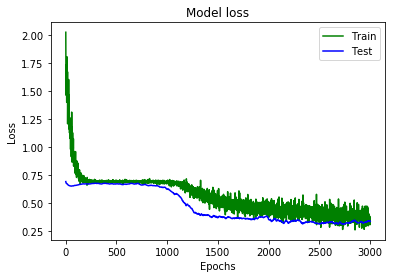

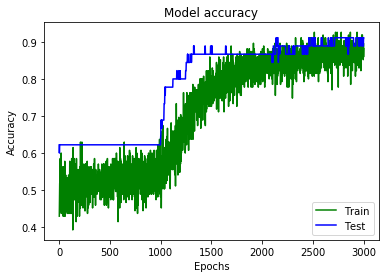

In [54]:
history = hist.history
iter_epochs = len(history['loss'])

def loss_accuracy_plot(iter_epochs, hist_dict):
    print('# Plotting the loss and accuracy metrics')
    epochs = range(1, iter_epochs+1)
    
    loss_values = hist_dict['loss']
    val_loss_values = hist_dict['val_loss']
    acc_values = hist_dict['acc']
    val_acc_values = hist_dict['val_acc']
    
    plt.plot(epochs, loss_values, 'g', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

    plt.clf()
    
    plt.plot(epochs, acc_values, 'g', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Model accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()

loss_accuracy_plot(iter_epochs, history)

In [55]:
predictions = model.predict(x=X_validation)
predictions = (predictions>0.5).astype(int)
print(accuracy_score(Y_validation, predictions))
#print(log_loss_function(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9111111111111111
[[27  1]
 [ 3 14]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        28
           1       0.93      0.82      0.87        17

   micro avg       0.91      0.91      0.91        45
   macro avg       0.92      0.89      0.90        45
weighted avg       0.91      0.91      0.91        45



In [28]:
final_scores= model.predict(x=X_test)

In [29]:
rows = zip(patient, final_scores)

with open('submit/submission.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

In [ ]:
# feature selection